In [1]:
import os, glob, platform
import numpy as np
import numpy.matlib
import pickle
import pandas as pd
import pathlib
import matplotlib
import matplotlib.pyplot as plt
import mne
mne.__version__
from mne.viz import plot_alignment, snapshot_brain_montage
import shutil
from mne.datasets import eegbci
from sklearn.model_selection import train_test_split

# from mne_bids import write_raw_bids, BIDSPath, print_dir_tree, make_dataset_description
# from mne_bids.stats import count_events
import sys


In [120]:
''' VARIABLES '''

dataset = 'eeg'

amount_of_subjects = 5 # Change the range so the process is faster

numC = 8

angles = [i * 180./numC for i in range(numC)]

x_labels = np.array(angles)

resample = False # speeds up the procees but showing worse results overall
resample_frequency = 20 # in Hz, original freq is 500Hz

In [121]:
from toolbox.methods import read_data
all_epochs, all_rawdata = read_data (task = 'main', resample=resample, amount_of_subjects=amount_of_subjects, resample_frequency=resample_frequency)

In [122]:
all_epochs[0].ch_names[31]

'Fz'

In [168]:
print(np.unique(all_rawdata[1]['metadata'].r_map, return_counts=True))

print(np.unique(all_rawdata[1]['metadata'].deci, return_counts=True))


(array([ 0, 45]), array([126, 135]))
(array([0, 1]), array([ 94, 167]))


In [173]:
all_rawdata[1]['metadata'][['resp', 'deci', 'r_map']]


,resp,deci,r_map
883,1.0,1,0
896,1.0,1,45
909,1.0,1,45
922,-1.0,0,0
935,1.0,1,45
...,...,...,...
4253,-1.0,0,45
4266,-1.0,0,0
4279,1.0,1,45
4292,1.0,1,45


In [180]:
y = np.where(all_rawdata[1]['metadata']['r_map'] == 45, 1, 0)

In [183]:
print(y)
np.unique(y, return_counts=True)

[0 1 1 0 1 0 1 1 0 0 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0
 1 0 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 0 1 0 0 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 0
 0 1 0 0 1 0 0 0 0 1 1 1 1 1 0 0 1 1 1 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 0 1 1
 0 0 1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0 0 1 0
 0 0 0 0 0 1 0 1 0 0 1 0 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 0 1 0 1 0
 1 0 0 0 1 1 1 0 0 0 0 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0
 1 0 1 1 0 1 0 0 0 0 0 0 1 1 1 1 0 1 0 0 1 0 1 1 1 1 0 1 1 1 0 0 0 0 1 0 1
 1 0]


(array([0, 1]), array([126, 135]))

In [179]:
all_rawdata[1]['metadata']['lr'] =np.where(all_rawdata[1]['metadata']['r_map'] == 45, 1, 0)

print(all_rawdata[1]['metadata'][['resp', 'deci', 'r_map', 'lr']])

      resp  deci  r_map  lr
883    1.0     1      0   0
896    1.0     1     45   1
909    1.0     1     45   1
922   -1.0     0      0   0
935    1.0     1     45   1
...    ...   ...    ...  ..
4253  -1.0     0     45   1
4266  -1.0     0      0   0
4279   1.0     1     45   1
4292   1.0     1     45   1
4305   1.0     1      0   0

[261 rows x 4 columns]


In [123]:
print(len(all_rawdata))
all_rawdata[0]['metadata'].columns

5


Index(['index', 'subj', 'nblock', 'ntrial', 'nrep', 'trial_type', 'cond-1',
       'cond', 'rDV', 'DV', 'resp', 'deci-2', 'deci-1', 'deci', 'corr-1',
       'r_map', 'correct', 'confi', 'RT', 'd1', 'conf_lvl', 'correct-1', 'd2',
       'd3', 'd4', 'd5', 'd6', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'confi-1',
       'conf_lvl-1'],
      dtype='object')

In [124]:
def diagonality(x):
    if x >= 0 and x <= 22.5:
        return 0
    elif x > 22.5 and x <= 67.5:
        return 1
    elif x > 67.5 and x <= 112.5:
        return 0
    elif x > 112.5 and x <= 157.5:
        return 1
    elif x > 157.5 and x <= 180:
        return 0

In [125]:
all_rawdata[0]['metadata'][['o1', 'o2', 'o3', 'o4', 'o5', 'o6']] *= 180 / np.pi
all_rawdata[0]['metadata']['o1'] = all_rawdata[0]['metadata']['o1'].apply(diagonality)

In [126]:
all_rawdata[0]['metadata']['o1']

883     1
896     1
909     1
922     0
935     0
       ..
4240    0
4253    0
4266    0
4279    1
4305    1
Name: o1, Length: 250, dtype: int64

In [148]:
'''7min for all subjects'''
use_timepoint = False
reshape = False
timepoint = 10
X = all_rawdata[4]['epoch_dat']
print(X.shape)
# X = X.reshape(X.shape[0],-1)
y = all_rawdata[4]['metadata']['deci']
y = np.array(y)
print(y.shape)

# for i in range(1, amount_of_subjects):
# 
#     X_temp = all_rawdata[i]['epoch_dat']
#     # X_temp = X_temp.reshape((X_temp.shape[0]*X_temp.shape[1], X_temp.shape[2]))
#     # shapes[i+1] = shapes[i] + X_temp.shape[0]
#     y_temp = all_rawdata[i]['metadata']['deci']
#     # y_temp = np.tile(y_temp, numC)
#     # X = np.vstack((X, X_temp))
#     X = np.concatenate((X, X_temp))
#     y = np.concatenate((y, y_temp))

print(X.shape, y.shape)
if use_timepoint: 
    X = X[:,:,timepoint]
else:
    if reshape:
        X = X.reshape(X.shape[0], -1)
print(X.shape, y.shape)
X = np.einsum('ijk->ikj',X)
X_eye = X[:,:,25]
X = np.delete(X, 25, axis=2)
X = np.delete(X, 30, axis=2)
X = np.einsum('ijk->ikj',X)
print(X.shape, y.shape)

(243, 32, 2876)
(243,)
(243, 32, 2876) (243,)
(243, 32, 2876) (243,)
(243, 30, 2876) (243,)


In [158]:
from sklearn.svm import SVC
# from pyrcn.echo_state_network import ESNClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from catboost import CatBoostClassifier
# from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import SVC

def train_timepoints(X, y, verbose=False, display_roc=False, acc_only = False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    minority = np.unique(y_train,return_counts=True)[1][0]
    mayority = np.unique(y_train,return_counts=True)[1][1]
    # print(mayority/minority)
    class_weight = {
        0: 1.0,  
        1: mayority/minority
    }
    sample_weights = np.array([class_weight[label] for label in y_train])
    
    clf = CatBoostClassifier(task_type = 'GPU')
    clf = RandomForestClassifier(random_state=0, n_jobs=-1)
    # clf = SVC() # Faster than Random Forest
    clf.fit(X_train, y_train,
            sample_weight=sample_weights
            )

    y_pred = clf.predict(X_test)    
    if verbose:
        print(classification_report(y_test, y_pred))
        print(np.unique(y_test, return_counts=True))
        print(np.unique(y_pred, return_counts=True))
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    features = clf.feature_importances_
    if display_roc:
        # I think this is not working
        from sklearn.metrics import roc_curve
        from sklearn.metrics import RocCurveDisplay
        fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=clf.classes_[1])
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
        return roc_display
    # if np.unique(y_pred, return_counts=True)[1].shape[0] == 1:
    #     unique_pred_0 = 0
    #     unique_pred_1 = np.unique(y_pred, return_counts=True)[1][0]  
    # else:
    #     unique_pred_0 = np.unique(y_pred, return_counts=True)[1][0]
    #     unique_pred_1 = np.unique(y_pred, return_counts=True)[1][1]
    if acc_only:
        return accuracy
    return accuracy, f1, roc, features

In [150]:
print(X.shape)
X = X[:,:,0:1800]
print(X.shape)

(243, 30, 1800)
(243, 30, 1800)


In [147]:
import random
print(y)
# random.shuffle(y)
print(y)
print(np.unique(y, return_counts=True))

[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1
 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1
 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1]
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1
 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1
 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1]
(array([0, 1

In [151]:
numT = X.shape[2]
timepoint_accuracy = [None]*numT
timepoint_f1 = [None]*numT
timepoint_roc = [None]*numT
features = [None]*numT
for timepoint in range(numT):
    print(timepoint)
    X_training = X[:,:,timepoint]
    timepoint_accuracy[timepoint], timepoint_f1[timepoint], timepoint_roc[timepoint], features[timepoint] = train_timepoints(X_training, y)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

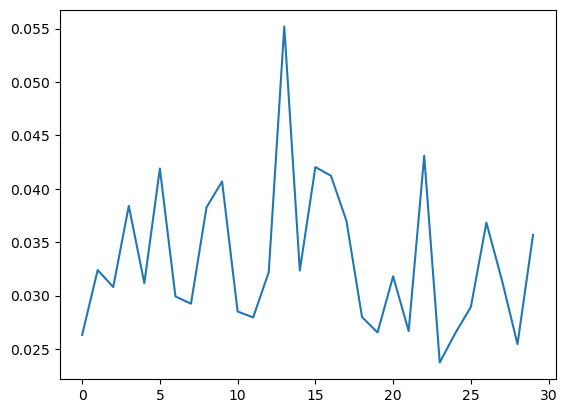

In [157]:
plt.plot(features[1500])

f1 mean:  0.6960800387914735
acc mean:  0.5537868480725624


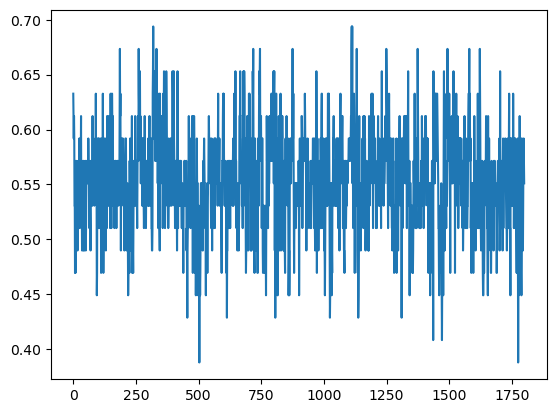

In [153]:
print('f1 mean: ', np.mean(timepoint_f1))
print('acc mean: ', np.mean(timepoint_accuracy))
plt.plot(timepoint_accuracy)
# plt.plot(unique_pred_0)

real data mean acc = 0.64

shuffled data mean acc = 0.58


# Mean acc for all subjects

In [ ]:
# MAKE A SLIDING TIMEPOINT WINDOW
subject_acc = [None]*amount_of_subjects
for subj in range(amount_of_subjects):
    numT = X.shape[2]
    timepoint_accuracy = [None]*numT
    print('Working on subj: ', subj)
    X = all_rawdata[subj]['epoch_dat']
    y = all_rawdata[subj]['metadata']['deci']
    y = np.array(y)
    for timepoint in range(numT):
        print(timepoint)
        X_training = X[:,:,timepoint]
        timepoint_accuracy[timepoint] = train_timepoints(X_training, y, verbose=False, acc_only=True)

# subject_acc[subj] = np.mean(timepoint_accuracy)
    

# RESULTS

In [ ]:
X_training = X[:,:,1500]
print(train_3(X_training, y, verbose=True))

In [ ]:
from sklearn.svm import SVC
# from pyrcn.echo_state_network import ESNClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
# from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# scaler = StandardScaler()

clf = CatBoostClassifier(task_type = 'GPU')
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set:", accuracy)



catboost and RF both on more data with stacked are perfoming the same

next im gonna add labels for the subjects


In [ ]:
display(all_rawdata[0]['metadata'].columns)

In [ ]:
print(multivariate)

# multivariate test?

https://pypi.org/project/pyts/

In [ ]:
from pyts.classification import BOSSVS
from pyts.multivariate.classification import MultivariateClassifier

from pyts.datasets import load_basic_motions

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# X_train, X_test, y_train, y_test = load_basic_motions(return_X_y=True)

print(X_train.shape, y_train.shape)

# scaler = StandardScaler()

clf = CatBoostClassifier(task_type = 'GPU')
clf = RandomForestClassifier()
clf = MultivariateClassifier(BOSSVS())
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set:", accuracy)

